# CT patient data input to model

In [30]:
!pip install opencv-python

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import tensorflow

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model

from joblib import dump, load

import re

You should consider upgrading via the '/home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


## Load model

In [31]:
# import model (labeled CT data)
model_labeledCT = load_model('../models/model_labeled_ct_15epochs')

## Read CT images + grayscale + resize

In [32]:
def read_ct_img_bydir(target_dir):
    img=cv2.imdecode(np.fromfile(target_dir,dtype=np.uint8),cv2.IMREAD_GRAYSCALE)
    #img = corp_margin(img)
    img=cv2.resize(img,(200,200))
    
    return img

## Get paths from all patient folders

In [33]:
def get_data_paths(main_dir):
    ct_paths = list()
    patient_ids = list()
    
    for dirs in os.listdir(main_dir):

        target_dir = f'../raw_data/CT_data/{dirs}/'
        sub_dir = os.listdir(target_dir)
        target_dir = target_dir+sub_dir[0]+'/'

        ct_paths.append(target_dir)
        patient_ids.append(dirs)
        
    return ct_paths

    #     for file in os.listdir(target_dir):
    #         if file.endswith(".jpg"):
    #             ct_paths.append(os.path.join(target_dir, file))

## Get data from one patient and store in array

In [34]:
def get_patient_data(data_path):
    '''Loads raw data from image names of each class folder and assigns a label to it.'''
    
    target_dir=data_path

    target_list=[target_dir+file for file in os.listdir(target_dir)]

#     y_list=to_categorical(np.concatenate(np.array([[0]*len(target_list1),
#                                                [1]*len(target_list2),
#                                                [2]*len(target_list3)])),3)

    X=np.array([read_ct_img_bydir(file) for file in target_list])[:,:,:,np.newaxis]

    return X

## Assign classification to prediction

In [42]:
def classify_prediction(prediction):
    
    y_pred_class = np.rint(prediction)
    classification = -999
    
    ni = y_pred_class[:,0].sum()
    pos = y_pred_class[:,1].sum()
    neg = y_pred_class[:,2].sum()
    
#     if neg > pos:
#         classification = 2 #negative
#     elif pos > neg:
#         classification = 1 #positive

    if pos > 0:
        classification = 1 #positive
    elif pos <= 0:
        classification = 2 #negative
    
    return classification, ni, pos, neg

## Extract patient ID from path

In [43]:
def get_patient_id(path):
    pattern = "Patient *[0-9]*"
    substring = re.search(pattern, path).group(0)
    return substring

In [44]:
main_dir = f'../raw_data/CT_data/'

ct_paths = get_data_paths(main_dir)

print(ct_paths)

path = ct_paths[0]

['../raw_data/CT_data/Patient 1264/CT/', '../raw_data/CT_data/Patient 534/CT/', '../raw_data/CT_data/Patient 1200/CT/', '../raw_data/CT_data/Patient 148/CT/', '../raw_data/CT_data/Patient 794/CT/', '../raw_data/CT_data/Patient 1215/CT/', '../raw_data/CT_data/Patient 375/CT/', '../raw_data/CT_data/Patient 1184/CT/', '../raw_data/CT_data/Patient 777/CT/', '../raw_data/CT_data/Patient 1177/CT/', '../raw_data/CT_data/Patient 121/CT/', '../raw_data/CT_data/Patient 1186/CT/', '../raw_data/CT_data/Patient 145/CT/', '../raw_data/CT_data/Patient 533/CT/', '../raw_data/CT_data/Patient 1180/CT/', '../raw_data/CT_data/Patient 1275/CT/', '../raw_data/CT_data/Patient 535/CT/', '../raw_data/CT_data/Patient 1188/CT/', '../raw_data/CT_data/Patient 1217/CT/', '../raw_data/CT_data/Patient 1179/CT/', '../raw_data/CT_data/Patient 1181/CT/', '../raw_data/CT_data/Patient 144/CT/', '../raw_data/CT_data/Patient 1185/CT/', '../raw_data/CT_data/Patient 1187/CT/', '../raw_data/CT_data/Patient 1182/CT/', '../raw_d

In [45]:
ct_paths

['../raw_data/CT_data/Patient 1264/CT/',
 '../raw_data/CT_data/Patient 534/CT/',
 '../raw_data/CT_data/Patient 1200/CT/',
 '../raw_data/CT_data/Patient 148/CT/',
 '../raw_data/CT_data/Patient 794/CT/',
 '../raw_data/CT_data/Patient 1215/CT/',
 '../raw_data/CT_data/Patient 375/CT/',
 '../raw_data/CT_data/Patient 1184/CT/',
 '../raw_data/CT_data/Patient 777/CT/',
 '../raw_data/CT_data/Patient 1177/CT/',
 '../raw_data/CT_data/Patient 121/CT/',
 '../raw_data/CT_data/Patient 1186/CT/',
 '../raw_data/CT_data/Patient 145/CT/',
 '../raw_data/CT_data/Patient 533/CT/',
 '../raw_data/CT_data/Patient 1180/CT/',
 '../raw_data/CT_data/Patient 1275/CT/',
 '../raw_data/CT_data/Patient 535/CT/',
 '../raw_data/CT_data/Patient 1188/CT/',
 '../raw_data/CT_data/Patient 1217/CT/',
 '../raw_data/CT_data/Patient 1179/CT/',
 '../raw_data/CT_data/Patient 1181/CT/',
 '../raw_data/CT_data/Patient 144/CT/',
 '../raw_data/CT_data/Patient 1185/CT/',
 '../raw_data/CT_data/Patient 1187/CT/',
 '../raw_data/CT_data/Pati

In [ ]:
pt_id_list = list()

for path in ct_paths:
    patient_id = get_patiend_id(path)
    pt_id_list.append(patient_id)
    

## Load model, get prediction & classification, create DataFrame

In [47]:
predictions = pd.DataFrame()
predictions['patient_id']=''
predictions['prediction']=''
predictions['niCT_slices']=''
predictions['pCT_slices']=''
predictions['nCT_slices']=''

for path in ct_paths:
    X = get_patient_data(path)
    print('Processing: ',path)
    y_pred = model_labeledCT.predict(X)

    patient_id = get_patient_id(path)
    
    classification, ni, pos, neg = classify_prediction(y_pred)
    total_ct = int(ni) + int(pos) + int(neg)
    #df = df.append({'a':1, 'b':2}, ignore_index=True)
    predictions = predictions.append({'patient_id': patient_id, 'prediction': classification, 'niCT_slices': ni, 'pCT_slices': pos,'nCT_slices':neg, 'total_CT_slices': total_ct}, ignore_index = True)    

Processing:  ../raw_data/CT_data/Patient 1264/CT/
Processing:  ../raw_data/CT_data/Patient 534/CT/
Processing:  ../raw_data/CT_data/Patient 1200/CT/
Processing:  ../raw_data/CT_data/Patient 148/CT/
Processing:  ../raw_data/CT_data/Patient 794/CT/
Processing:  ../raw_data/CT_data/Patient 1215/CT/
Processing:  ../raw_data/CT_data/Patient 375/CT/
Processing:  ../raw_data/CT_data/Patient 1184/CT/
Processing:  ../raw_data/CT_data/Patient 777/CT/
Processing:  ../raw_data/CT_data/Patient 1177/CT/
Processing:  ../raw_data/CT_data/Patient 121/CT/
Processing:  ../raw_data/CT_data/Patient 1186/CT/
Processing:  ../raw_data/CT_data/Patient 145/CT/
Processing:  ../raw_data/CT_data/Patient 533/CT/
Processing:  ../raw_data/CT_data/Patient 1180/CT/
Processing:  ../raw_data/CT_data/Patient 1275/CT/
Processing:  ../raw_data/CT_data/Patient 535/CT/
Processing:  ../raw_data/CT_data/Patient 1188/CT/
Processing:  ../raw_data/CT_data/Patient 1217/CT/
Processing:  ../raw_data/CT_data/Patient 1179/CT/
Processin

In [51]:
predictions.sort_values(by='prediction', ascending=True)

,patient_id,prediction,niCT_slices,pCT_slices,nCT_slices,total_CT_slices
14,Patient 1180,1,73.0,15.0,57.0,145.0
25,Patient 1265,1,45.0,89.0,20.0,154.0
17,Patient 1188,1,52.0,5.0,84.0,141.0
13,Patient 533,1,106.0,6.0,182.0,294.0
12,Patient 145,1,90.0,238.0,16.0,344.0
11,Patient 1186,1,91.0,2.0,116.0,209.0
9,Patient 1177,1,71.0,1.0,127.0,199.0
8,Patient 777,1,91.0,131.0,9.0,231.0
28,Patient 1178,1,67.0,2.0,68.0,137.0
1,Patient 534,1,75.0,5.0,203.0,283.0


# Explore Data

In [13]:
# get data of all patients in list or directory

In [58]:
X1 = get_patient_data('Patient 751')

In [59]:
X2 = get_patient_data('Patient 806')

In [187]:
X3 = get_patient_data('Patient 805b')

In [60]:
X1.shape

(139, 200, 200, 1)

In [61]:
X2.shape

(220, 200, 200, 1)

In [188]:
X3.shape

(51, 200, 200, 1)

In [131]:
y1_pred = model_labeledCT.predict(X1)
y1_pred.shape

(139, 3)

In [63]:
y2_pred = model_labeledCT.predict(X2)

In [189]:
y3_pred = model_labeledCT.predict(X3)

In [132]:
y1_pred_class = np.rint(y1_pred)
y1_pred_class.shape

(139, 3)

In [159]:
y2_pred_class = np.rint(y2_pred)
y2_pred_class[:,2].sum()

22.0

In [190]:
y3_pred_class = np.rint(y3_pred)

In [133]:
y1_pred_class = y1_pred_class.astype(int);
y1_pred_class.shape

(139, 3)

In [125]:
y2_pred_class = y2_pred_class.astype(int);
y2_pred_class;

In [191]:
y3_pred_class = y3_pred_class.astype(int);
y3_pred_class.shape

(51, 3)

In [176]:
# number negative CTs
neg1 = y1_pred_class[:,2].sum()
neg1

73

In [170]:
test = list(y1_pred_class)

In [171]:
y_pred_class.sum()

139.0

In [172]:
# number positive CTs
pos1 = y1_pred_class[:,1].sum()
pos1

0

In [177]:
# number non-informative CTs
ni1 = y1_pred_class[:,0].sum()
ni1

66

In [178]:
# number negative CTs
neg2 = y2_pred_class[:,2].sum()

In [179]:
# number positive CTs
pos2 = y2_pred_class[:,1].sum()

In [180]:
# number non-informative CTs
ni2 = y2_pred_class[:,0].sum()

In [192]:
# number negative CTs
neg3 = y3_pred_class[:,2].sum()

In [193]:
# number positive CTs
pos3 = y3_pred_class[:,1].sum()

In [194]:
# number non-informative CTs
ni3 = y3_pred_class[:,0].sum()

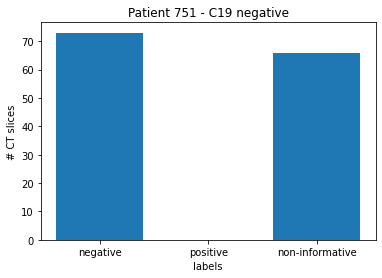

In [184]:
plt.bar(['negative', 'positive', 'non-informative'],[neg1, pos1, ni1])
plt.title('Patient 751 - C19 negative');
plt.ylabel('# CT slices');
plt.xlabel('labels');

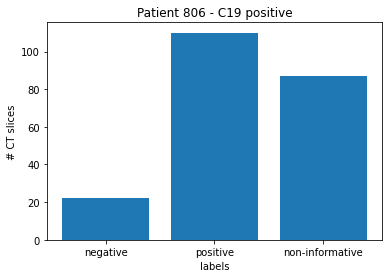

In [185]:
plt.bar(['negative', 'positive', 'non-informative'],[neg2, pos2, ni2])
plt.title('Patient 806 - C19 positive');
plt.ylabel('# CT slices');
plt.xlabel('labels');

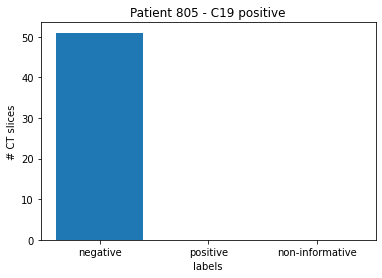

In [195]:
plt.bar(['negative', 'positive', 'non-informative'],[neg3, pos3, ni3])
plt.title('Patient 805 - C19 positive');
plt.ylabel('# CT slices');
plt.xlabel('labels');